# Integration with plato-draw, 3D Voronoi and Voxelization
The [plato-draw](https://plato-draw.readthedocs.io/) package allows for visualizing particle data in 2D and 3D using a variety of backend libraries. Here, we show a 3D Voronoi diagram drawn using [fresnel](https://fresnel.readthedocs.io/) and [pythreejs](https://github.com/jupyter-widgets/pythreejs). We use [rowan](https://rowan.readthedocs.io/) to generate the view rotation.

In [1]:
import freud
import matplotlib.cm
import numpy as np
import rowan
from util import make_fcc
import plato.draw.fresnel
import plato.draw.pythreejs
backend = plato.draw.fresnel
# For interactive scenes:
# import plato.draw.pythreejs
# backend = plato.draw.pythreejs

In [2]:
def plot_crystal(box, positions, colors=None, radii=None, backend=None,
                 polytopes=[], polytope_colors=None):
    if backend is None:
        backend = plato.draw.fresnel
    if colors is None:
        colors = np.array([[0.5, 0.5, 0.5, 1]] * len(positions))
    if radii is None:
        radii = np.array([0.5] * len(positions))
    sphere_prim = backend.Spheres(positions=positions, colors=colors, radii=radii)
    box_prim = backend.Lines(
        start_points=[box.makeCoordinates([0, 0, 0]),
                      box.makeCoordinates([0, 0, 0]),
                      box.makeCoordinates([0, 0, 0]),
                      box.makeCoordinates([1, 1, 0]),
                      box.makeCoordinates([1, 1, 0]),
                      box.makeCoordinates([1, 1, 0]),
                      box.makeCoordinates([0, 1, 1]),
                      box.makeCoordinates([0, 1, 1]),
                      box.makeCoordinates([0, 1, 1]),
                      box.makeCoordinates([1, 0, 1]),
                      box.makeCoordinates([1, 0, 1]),
                      box.makeCoordinates([1, 0, 1])],
        end_points=[box.makeCoordinates([1, 0, 0]),
                    box.makeCoordinates([0, 1, 0]),
                    box.makeCoordinates([0, 0, 1]),
                    box.makeCoordinates([1, 0, 0]),
                    box.makeCoordinates([0, 1, 0]),
                    box.makeCoordinates([1, 1, 1]),
                    box.makeCoordinates([1, 1, 1]),
                    box.makeCoordinates([0, 1, 0]),
                    box.makeCoordinates([0, 0, 1]),
                    box.makeCoordinates([0, 0, 1]),
                    box.makeCoordinates([1, 1, 1]),
                    box.makeCoordinates([1, 0, 0])],
        widths=0.1,
        colors=[0, 0, 0, 1])
    if polytope_colors is None:
        polytope_colors = colors * np.array([1, 1, 1, 0.4])
    polytope_prims = []
    for p, c in zip(polytopes, polytope_colors):
        p_prim = backend.ConvexPolyhedra(
            positions=[[0, 0, 0]], colors=c, vertices=p, outline=0)
        polytope_prims.append(p_prim)
    rotation = rowan.multiply(
        rowan.from_axis_angle([1, 0, 0], np.pi/10),
        rowan.from_axis_angle([0, 1, 0], -np.pi/10))
    scene = backend.Scene([sphere_prim, box_prim, *polytope_prims],
                          zoom=3, rotation=rotation)
    if backend is not plato.draw.fresnel:
        scene.enable('directional_light')
    #else:
    #    scene.enable('antialiasing')
    scene.show()

We generate an fcc structure and add Gaussian noise to the positions. Colors are assigned randomly.

In [3]:
np.random.seed(12)
box, positions = make_fcc(nx=2, ny=2, nz=2, scale=1.5, noise=0.2)
positions = box.wrap(positions)
cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap(np.random.rand(len(positions)))

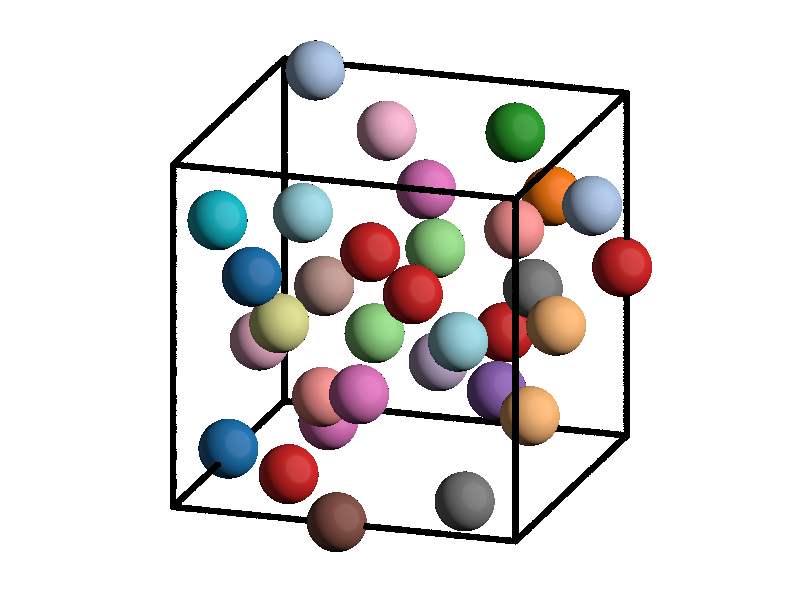

In [4]:
plot_crystal(box, positions, colors, backend=backend)

We make a Voronoi tesselation of the system and plot it in 3D. The Voronoi cells are approximately [rhombic dodecahedra](https://en.wikipedia.org/wiki/Rhombic_dodecahedron), which tesselate 3D space in a face-centered cubic lattice.

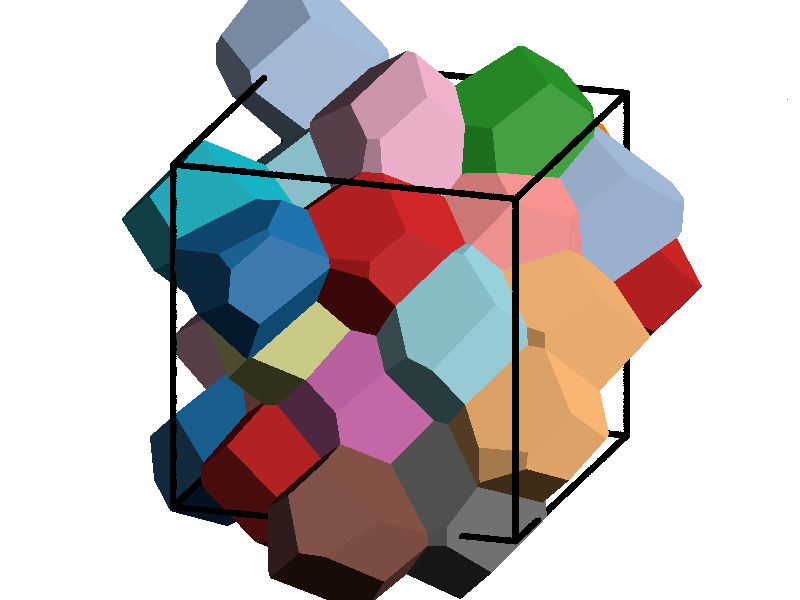

In [5]:
voro = freud.voronoi.Voronoi(box)
voro.compute(positions, buff=np.max(box.L)/2)
plot_crystal(box, positions, colors=colors,
             backend=backend, polytopes=voro.polytopes)

We generate a voxelization of this space by creating a dense lattice of points on a simple cubic lattice.

In [6]:
def make_cubic_grid(box, voxels_per_side):
    v_space = np.linspace(0, 1, voxels_per_side+1)
    v_space = (v_space[:-1] + v_space[1:])/2  # gets centers of the voxels
    return np.array([box.makeCoordinates([x, y, z])
                     for x in v_space for y in v_space for z in v_space])

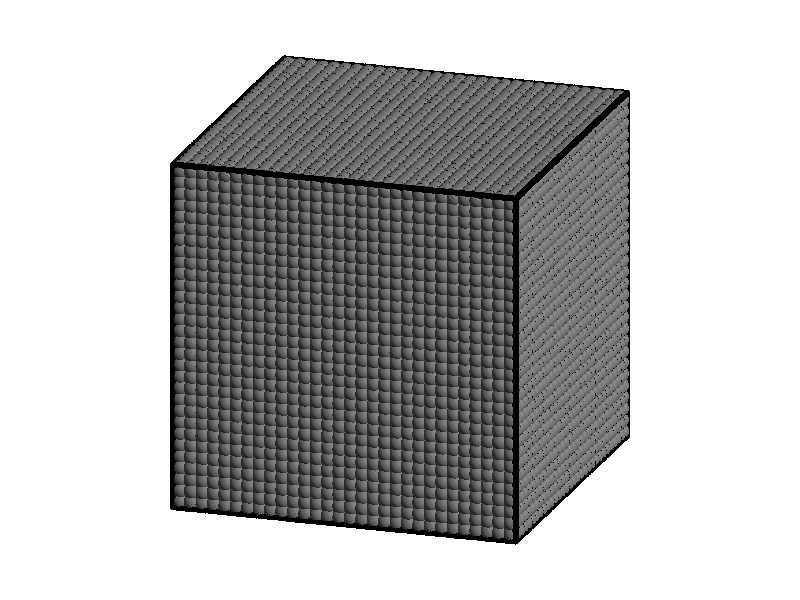

In [7]:
voxels_per_side = 30
cubic_grid = make_cubic_grid(box, voxels_per_side)

# Make the spheres overlap just a bit
radii = np.ones(len(cubic_grid)) * 0.8 * np.max(box.L) / voxels_per_side

plot_crystal(box, cubic_grid, radii=radii, backend=backend)

We color the voxels by their first nearest neighbor. This is mathematically equivalent to being inside the corresponding Voronoi cell. Here, we get the neighbor indices (this can be used to separate the Voronoi cells into voxels).

In [8]:
nn = freud.locality.NearestNeighbors(rmax=1, n_neigh=1)
nn.compute(box, cubic_grid, positions)
voxel_neighbors = -np.ones(len(cubic_grid), dtype=np.int)
for i, j in zip(nn.nlist.index_i, nn.nlist.index_j):
    voxel_neighbors[i] = j

Next, we use these indices to color and draw the voxelization.

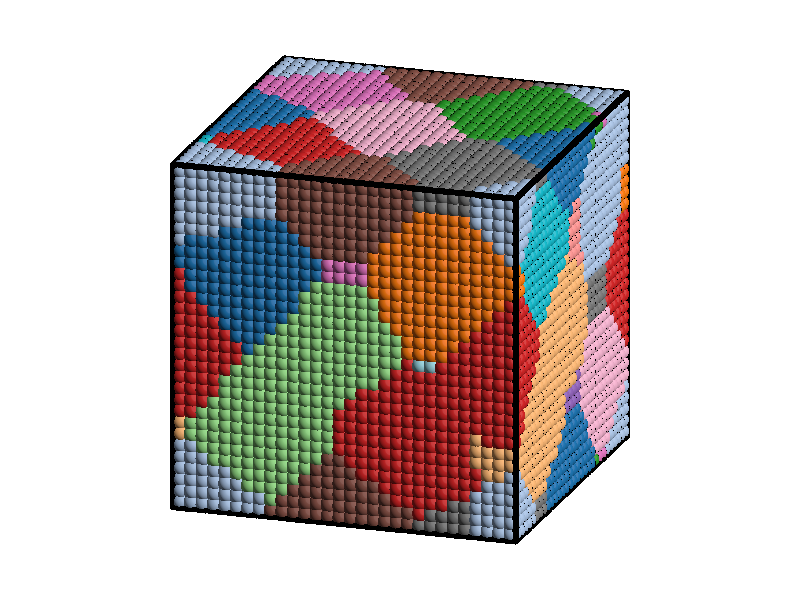

In [9]:
voxel_colors = np.array([colors[i] for i in voxel_neighbors])
plot_crystal(box, cubic_grid, colors=voxel_colors,
             radii=radii, backend=backend)